In [6]:
import torch
from transformers import AutoModel, AutoModelForCausalLM, AutoTokenizer
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm
import os
cache_dir = "../cache"
os.environ['TRANSFORMERS_CACHE'] = cache_dir

hf_token = "huggingface token here"
#model_id = "meta-llama/Meta-Llama-3.1-8B"
#model_id =  "mistralai/Mistral-7B-Instruct-v0.3"
model_id = "microsoft/Phi-3-medium-4k-instruct"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0", 
    torch_dtype="auto",
    trust_remote_code=True,
    cache_dir=cache_dir, 
    token=hf_token
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

# # Load pre-trained model and tokenizer
# model_name = "bert-base-uncased"  # or any other suitable model
# model = AutoModel.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)

def get_embeddings(texts, layer=-1):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to('cuda:0')
    # with torch.no_grad():
    #     outputs = model(**inputs)
    # # Get embeddings from the specified layer
    # embeddings = outputs.logits
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    # Get embeddings from the specified layer
    embeddings = outputs.hidden_states[layer]
    # Mean pooling
    attention_mask = inputs['attention_mask'].unsqueeze(-1)
    embeddings = torch.sum(embeddings * attention_mask, 1) / torch.clamp(attention_mask.sum(1), min=1e-9)
    return embeddings.cpu().numpy()



`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attenton` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [2]:
inputs = tokenizer(["This is sentence 1", "This is sentence 2"], return_tensors="pt", padding=True, truncation=True).to('cuda:0')
with torch.no_grad():
    outputs = outputs = model(**inputs, output_hidden_states=True)
embeddings = outputs.hidden_states[-1]
# Mean pooling
attention_mask = inputs['attention_mask'].unsqueeze(-1)
embeddings = torch.sum(embeddings * attention_mask, 1) / torch.clamp(attention_mask.sum(1), min=1e-9)
# Get embeddings from the specified layer


You are not running the flash-attention implementation, expect numerical differences.


In [5]:
embeddings[0].shape

torch.Size([5120])

In [3]:
logits = outputs.logits
print(logits)

tensor([[[  6.3438,   8.3750,  12.8125,  ...,  -4.3750,  -4.3750,  -4.3750],
         [  1.6641,  -0.7148,  -0.5117,  ...,  -8.5000,  -8.5000,  -8.5000],
         [  0.3301,  -0.4121,  -0.9219,  ...,  -8.5625,  -8.5625,  -8.5625],
         [  4.1875,   2.5938,   6.7500,  ..., -10.0000, -10.0000, -10.0000],
         [ -0.5547,  -4.0938,   3.4375,  ...,   1.2188,   1.2188,   1.2188],
         [ 10.3125,   7.0312,   7.3750,  ...,  -7.6875,  -7.6875,  -7.6875]],

        [[  6.3438,   8.3750,  12.8125,  ...,  -4.3750,  -4.3750,  -4.3750],
         [  1.6641,  -0.7148,  -0.5117,  ...,  -8.5000,  -8.5000,  -8.5000],
         [  0.3301,  -0.4121,  -0.9219,  ...,  -8.5625,  -8.5625,  -8.5625],
         [  4.1875,   2.5938,   6.7500,  ..., -10.0000, -10.0000, -10.0000],
         [ -0.5547,  -4.0938,   3.4375,  ...,   1.2188,   1.2188,   1.2188],
         [  9.7500,   6.5938,   6.7500,  ...,  -8.8125,  -8.8125,  -8.8125]]],
       device='cuda:0')


In [4]:
embeddings = outputs.hidden_states[-1]
print(embeddings)

tensor([[[ 1.6484,  2.4219,  0.7773,  ..., -1.6953,  1.7656,  2.8594],
         [ 2.1875, -1.4453, -1.4688,  ..., -2.2344,  0.3301, -0.8945],
         [-0.2520, -1.1406, -5.9375,  ..., -1.0703, -0.3848,  0.8906],
         [-3.4844,  2.5781,  1.2969,  ..., -0.4707,  1.4141, -1.3281],
         [-4.5625, -1.7031,  3.9844,  ..., -0.2598, -0.5469,  0.8438],
         [-1.2734,  0.9297,  1.4297,  ...,  3.1094,  0.4023,  0.2051]],

        [[ 1.6484,  2.4219,  0.7773,  ..., -1.6953,  1.7656,  2.8594],
         [ 2.1875, -1.4453, -1.4688,  ..., -2.2344,  0.3301, -0.8945],
         [-0.2520, -1.1406, -5.9375,  ..., -1.0703, -0.3848,  0.8906],
         [-3.4844,  2.5781,  1.2969,  ..., -0.4707,  1.4141, -1.3281],
         [-4.5625, -1.7031,  3.9844,  ..., -0.2598, -0.5469,  0.8438],
         [-1.5781,  1.7031,  1.6875,  ...,  2.8125,  0.3438, -0.1504]]],
       device='cuda:0', dtype=torch.bfloat16)


In [5]:
# Mean pooling
attention_mask = inputs['attention_mask'].unsqueeze(-1)
embeddings = torch.sum(embeddings * attention_mask, 1) / torch.clamp(attention_mask.sum(1), min=1e-9)

In [6]:
embeddings

tensor([[-0.9583,  0.2734,  0.0137,  ..., -0.4375,  0.4974,  0.4297],
        [-1.0052,  0.4010,  0.0566,  ..., -0.4870,  0.4870,  0.3698]],
       device='cuda:0')

In [7]:
import pandas as pd

aae_sae = pd.read_csv("./Complete Dataset/some-removed/Phi-3-medium-SAE.csv")

# Prepare parallel corpus
aae_texts = aae_sae["african_american_english"][:100].to_list()
sae_texts = aae_sae["standard_american_english"][:100].to_list()


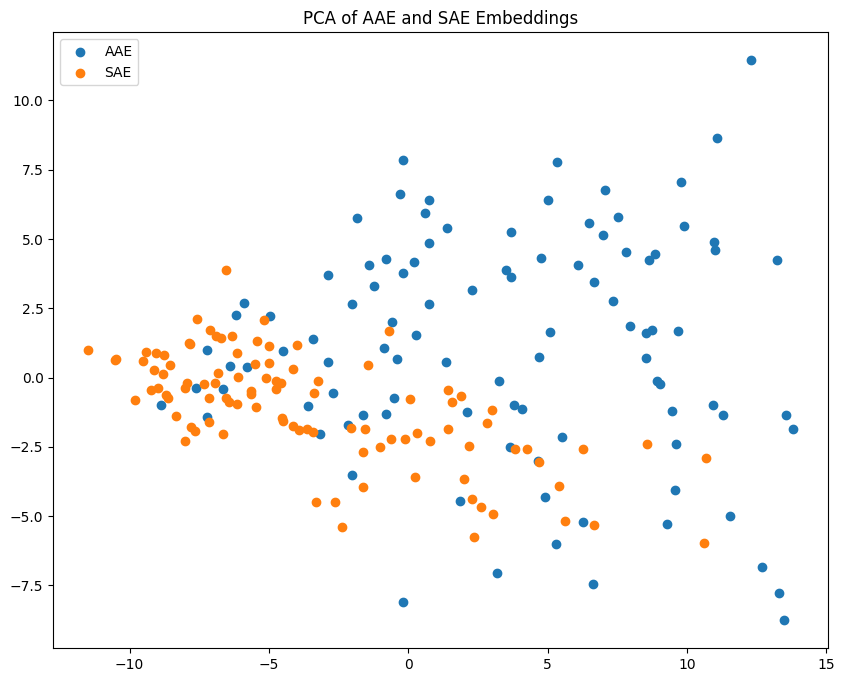

Average alignment score: 0.11407937854528427


In [8]:
# Get embeddings
aae_embeddings = get_embeddings(aae_texts)
sae_embeddings = get_embeddings(sae_texts)

# Perform PCA
pca = PCA(n_components=2)
combined_embeddings = np.vstack((aae_embeddings, sae_embeddings))
pca_result = pca.fit_transform(combined_embeddings)

# Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:len(aae_texts), 0], pca_result[:len(aae_texts), 1], label='AAE')
plt.scatter(pca_result[len(aae_texts):, 0], pca_result[len(aae_texts):, 1], label='SAE')
plt.legend()
plt.title('PCA of AAE and SAE Embeddings')
plt.savefig("PCA_AAE_SAE.png")
plt.show()

# Calculate alignment score
def alignment_score(emb1, emb2):
    return np.mean(np.abs(emb1 - emb2))

avg_alignment = np.mean([alignment_score(aae_embeddings[i], sae_embeddings[i]) for i in range(len(aae_texts))])
print(f"Average alignment score: {avg_alignment}")

Alignment Score: 0.06822307443762816

Closest AAE-SAE Pairs:
AAE: Spend less time focusing on what you did wrong and more time focusing on how to never let it happen again.
SAE: Spend less time focusing on what you did wrong and more time focusing on how to ensure it never happens again.
Similarity: 0.9995

AAE: @MrsStealUrGurl I can't treat but if you find a friend makes sure he has another.
SAE: @MrsStealUrGurl I can't treat, but if you find a friend, make sure he has another.
Similarity: 0.9994

AAE: I guess I need to lightly toast this bread so I can make a sandwich. Cause using the microwave proved to be a failure
SAE: I suppose I need to lightly toast this bread so I can make a sandwich, because using the microwave proved to be a failure.
Similarity: 0.9992

AAE: Can't believe I came home at 4 and sat around in my jeans until just now. That's a first.
SAE: I can't believe I came home at 4 and sat around in my jeans until just now. That's a first.
Similarity: 0.9985

AAE: She didn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


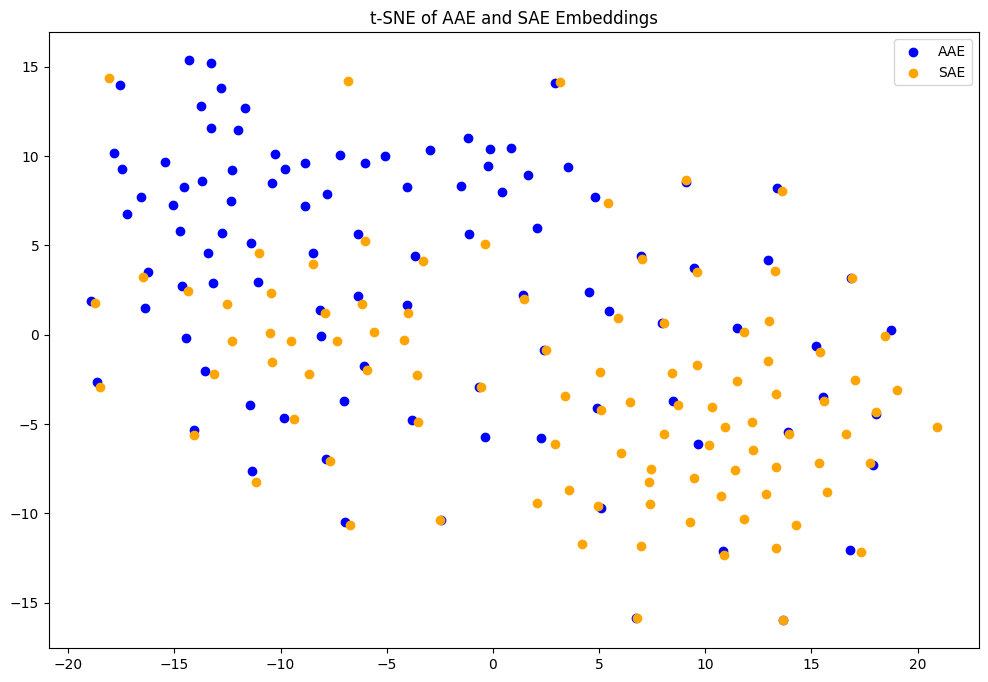


AAE Outliers:
Text: The bul Mike James from @mavs ain't shit n he dumb as shit. #nba #dallasmavs
Distance from mean: 16.0500

Text: Swear iCut Everybody Off But These Tha Type Of Games You Choose To Play  Bet That Up
Distance from mean: 16.7473

Text: As Much As iWanted Him In Ha Life iJust Cant Keep Letting Him Run In &amp;' Out Of Ha Life
Distance from mean: 18.7075

Text: When people email you instead of texting or calling that means they shouldn't be talking to you in the first place.
Distance from mean: 16.0246

Text: Dat shyt gone put me rite bak ta sleep n dats wastin it .... nvm
Distance from mean: 17.3860


SAE Outliers:
Text: The player Mike James from the Mavs is not impressive and he is not very smart. #NBA #DallasMavs
Distance from mean: 15.2677

Text: @KardinalRule @PAUL_THE_GREAT Was that supposed to be a joke? Not funny! Better luck next time! :-) 
Distance from mean: 17.3901

Text: @iamfocus @melvinwjr @MaJorMaJeed ha ha ha that class from 1997 to 2002 was really smoo

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import wasserstein_distance

def calculate_alignment_score(embeddings1, embeddings2):
    """Calculate alignment score using Wasserstein distance."""
    distances = []
    for dim in range(embeddings1.shape[1]):
        distance = wasserstein_distance(embeddings1[:, dim], embeddings2[:, dim])
        distances.append(distance)
    return np.mean(distances)

def find_closest_pairs(aae_embeddings, sae_embeddings, aae_texts, sae_texts, top_k=5):
    """Find the closest AAE-SAE sentence pairs."""
    similarities = cosine_similarity(aae_embeddings, sae_embeddings)
    closest_pairs = []
    for i in range(len(aae_texts)):
        top_indices = np.argsort(similarities[i])[::-1][:top_k]
        for j in top_indices:
            closest_pairs.append((aae_texts[i], sae_texts[j], similarities[i][j]))
    return sorted(closest_pairs, key=lambda x: x[2], reverse=True)[:top_k]

def find_furthest_pairs(aae_embeddings, sae_embeddings, aae_texts, sae_texts, top_k=5):
    """Find the most dissimilar AAE-SAE sentence pairs."""
    similarities = cosine_similarity(aae_embeddings, sae_embeddings)
    furthest_pairs = []
    for i in range(len(aae_texts)):
        bottom_indices = np.argsort(similarities[i])[:top_k]
        for j in bottom_indices:
            furthest_pairs.append((aae_texts[i], sae_texts[j], similarities[i][j]))
    return sorted(furthest_pairs, key=lambda x: x[2])[:top_k]

def plot_tsne(aae_embeddings, sae_embeddings, aae_texts, sae_texts):
    """Create t-SNE plot of embeddings."""
    combined_embeddings = np.vstack((aae_embeddings, sae_embeddings))
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(combined_embeddings)
    
    plt.figure(figsize=(12, 8))
    plt.scatter(tsne_result[:len(aae_embeddings), 0], tsne_result[:len(aae_embeddings), 1], c='blue', label='AAE')
    plt.scatter(tsne_result[len(aae_embeddings):, 0], tsne_result[len(aae_embeddings):, 1], c='orange', label='SAE')
    plt.legend()
    plt.title('t-SNE of AAE and SAE Embeddings')
    plt.show()
    
    return tsne_result

def analyze_embeddings(aae_embeddings, sae_embeddings, aae_texts, sae_texts):
    """Perform comprehensive analysis on embeddings."""
    # Calculate alignment score
    alignment_score = calculate_alignment_score(aae_embeddings, sae_embeddings)
    print(f"Alignment Score: {alignment_score}")
    
    # Find closest pairs
    print("\nClosest AAE-SAE Pairs:")
    closest_pairs = find_closest_pairs(aae_embeddings, sae_embeddings, aae_texts, sae_texts)
    for aae, sae, sim in closest_pairs:
        print(f"AAE: {aae}")
        print(f"SAE: {sae}")
        print(f"Similarity: {sim:.4f}\n")
    
    # Find furthest pairs
    print("\nMost Dissimilar AAE-SAE Pairs:")
    furthest_pairs = find_furthest_pairs(aae_embeddings, sae_embeddings, aae_texts, sae_texts)
    for aae, sae, sim in furthest_pairs:
        print(f"AAE: {aae}")
        print(f"SAE: {sae}")
        print(f"Similarity: {sim:.4f}\n")
    
    # Create t-SNE plot
    tsne_result = plot_tsne(aae_embeddings, sae_embeddings, aae_texts, sae_texts)
    
    return alignment_score, closest_pairs, furthest_pairs, tsne_result

# Assuming you have aae_embeddings, sae_embeddings, aae_texts, and sae_texts
# Run the analysis
alignment_score, closest_pairs, furthest_pairs, tsne_result = analyze_embeddings(aae_embeddings, sae_embeddings, aae_texts, sae_texts)

# Additional analysis: Investigate outliers
def find_outliers(embeddings, texts, n_std=2):
    """Find outlier sentences based on their distance from the mean embedding."""
    mean_embedding = np.mean(embeddings, axis=0)
    distances = np.linalg.norm(embeddings - mean_embedding, axis=1)
    threshold = np.mean(distances) + n_std * np.std(distances)
    outlier_indices = np.where(distances > threshold)[0]
    return [(texts[i], distances[i]) for i in outlier_indices]

print("\nAAE Outliers:")
aae_outliers = find_outliers(aae_embeddings, aae_texts)
for text, distance in aae_outliers:
    print(f"Text: {text}")
    print(f"Distance from mean: {distance:.4f}\n")

print("\nSAE Outliers:")
sae_outliers = find_outliers(sae_embeddings, sae_texts)
for text, distance in sae_outliers:
    print(f"Text: {text}")
    print(f"Distance from mean: {distance:.4f}\n")

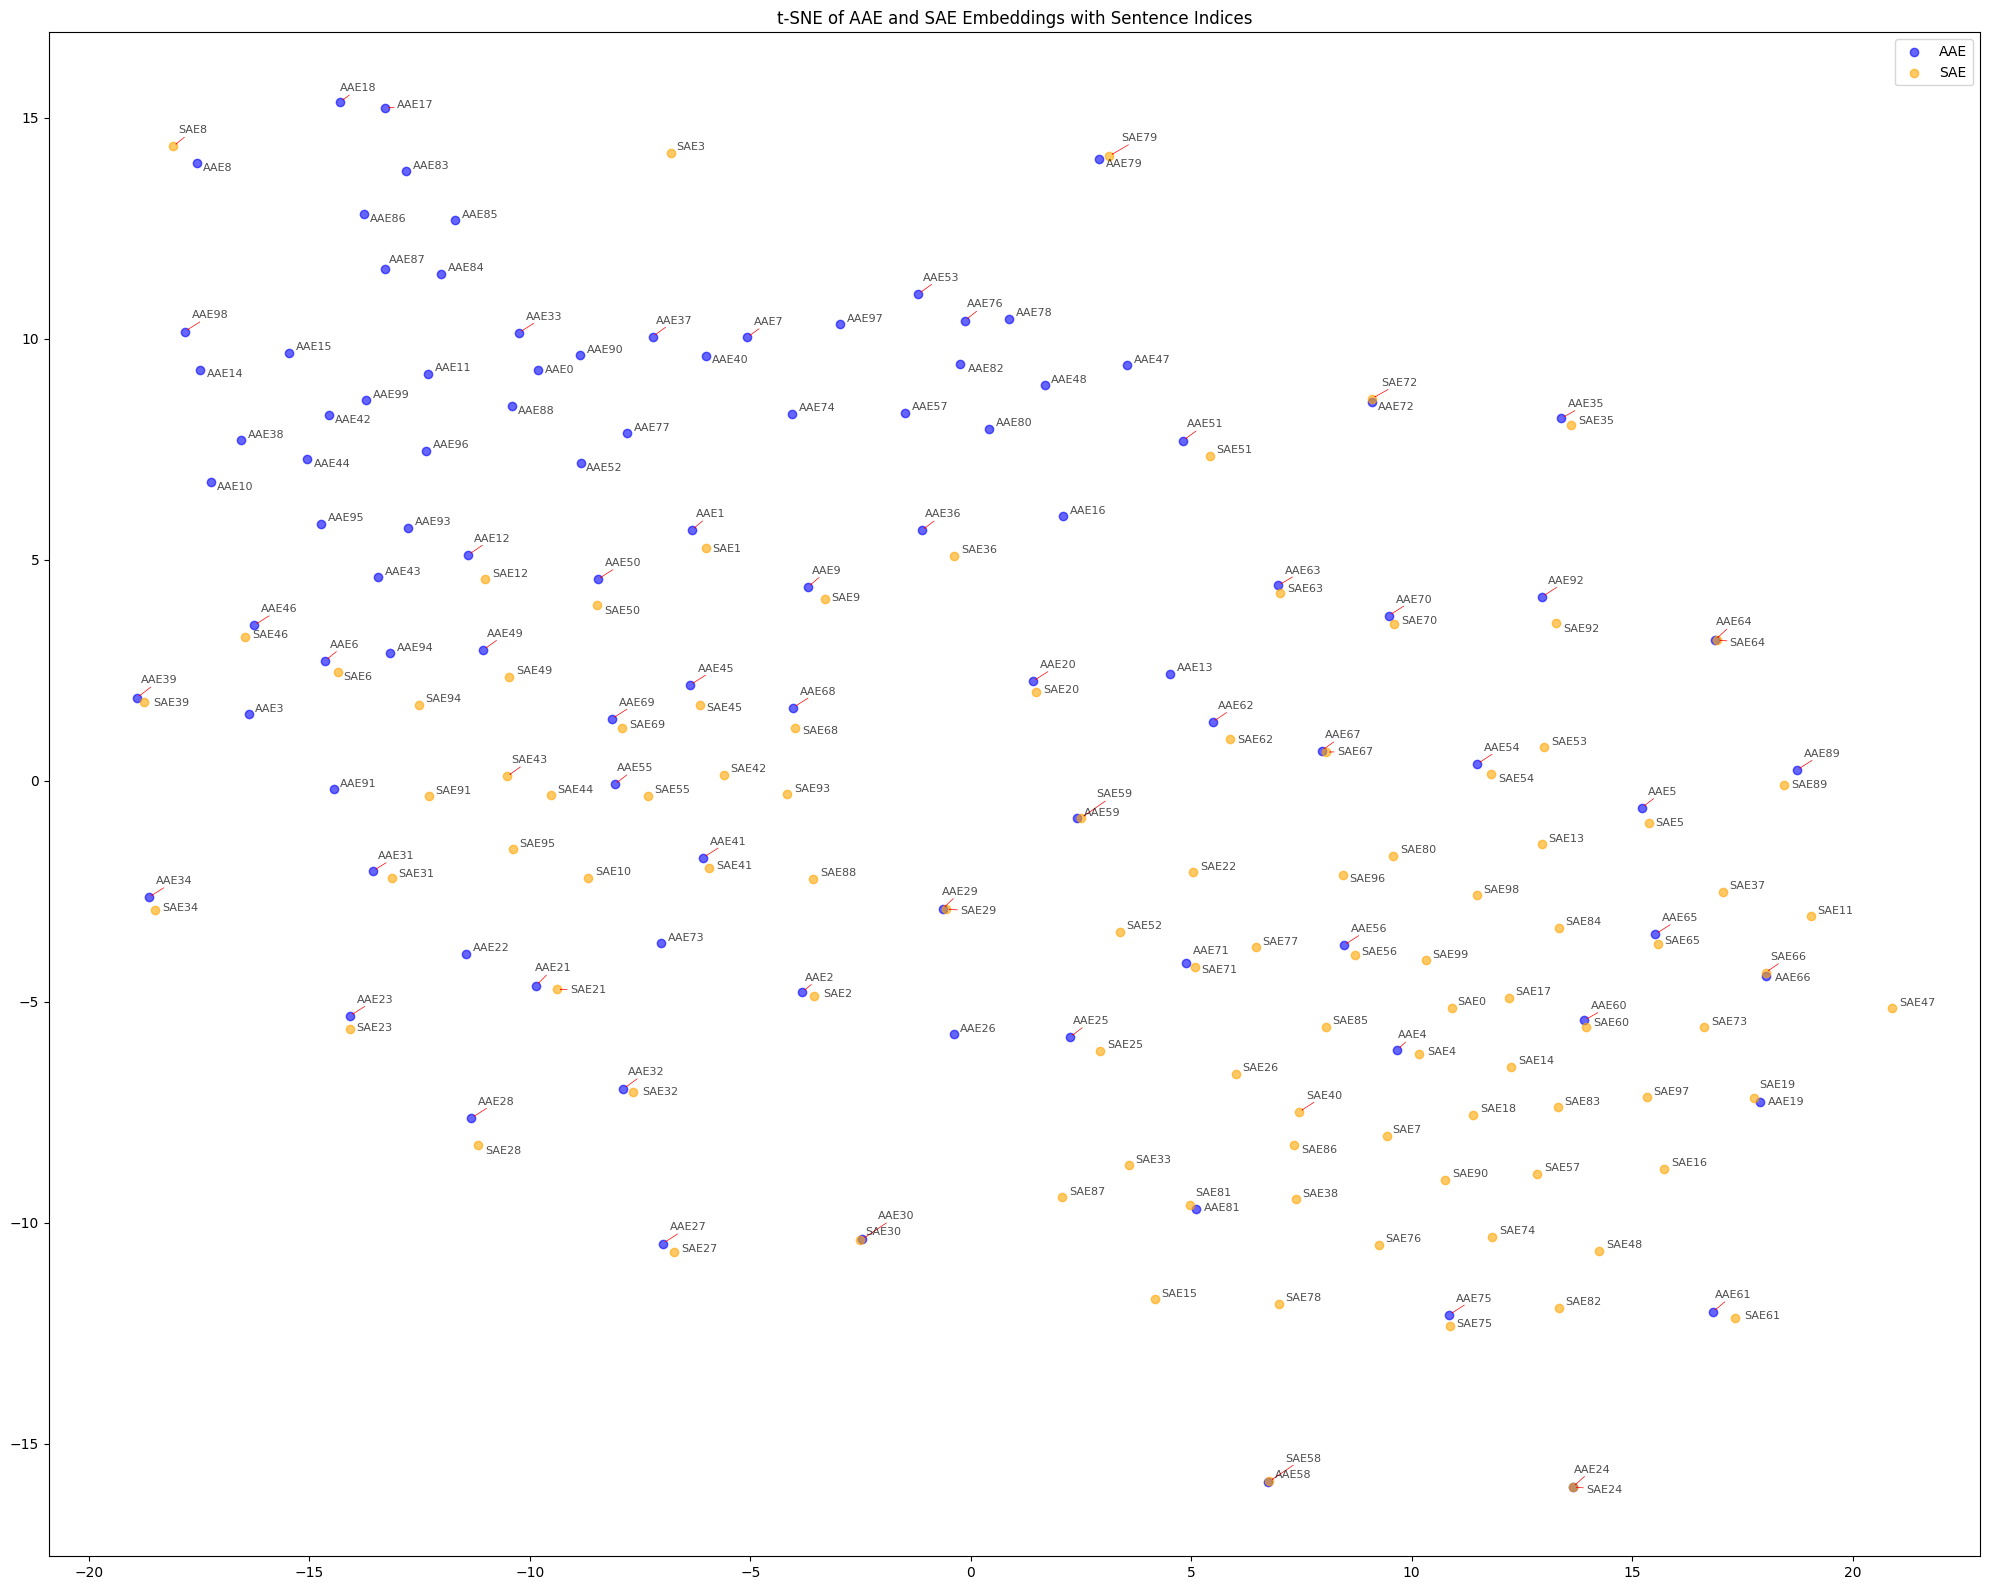


Pairs with Largest t-SNE Distances:
AAE18: As Much As iWanted Him In Ha Life iJust Cant Keep Letting Him Run In &amp;' Out Of Ha Life
SAE18: As much as I wanted him in my life, I just can't keep letting him run in and out of it.
Distance: 34.4390

AAE11: Call up 2 diz skool, I should have never took my ass 2 college fuck that shit
SAE11: Call up to these schools; I should have never taken myself to college. I reject that idea.
Distance: 33.6765

AAE14: Loved da tyme i spent wit my guy dat fool kno he kept me laughing i guess thtz,all tht matters
SAE14: I loved the time I spent with my friend who always knew how to keep me laughing; I guess that's all that matters.
Distance: 33.6581

AAE83: Sometimes ii Feel ii talk Da Most Shit..Bt Den ii B Like..Who Da Fukk Gone Check Me..??
SAE83: Sometimes I feel like I talk the most nonsense, but then I realize that no one is really paying attention to me.
Distance: 33.6359

AAE17: Swear iCut Everybody Off But These Tha Type Of Games You Choose To

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

def plot_tsne_with_labels(aae_embeddings, sae_embeddings, aae_texts, sae_texts):
    """Create t-SNE plot of embeddings with sentence index labels."""
    combined_embeddings = np.vstack((aae_embeddings, sae_embeddings))
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(combined_embeddings)
    
    plt.figure(figsize=(20, 16))
    
    # Plot AAE points
    aae_scatter = plt.scatter(tsne_result[:len(aae_embeddings), 0], 
                              tsne_result[:len(aae_embeddings), 1], 
                              c='blue', label='AAE', alpha=0.6)
    
    # Plot SAE points
    sae_scatter = plt.scatter(tsne_result[len(aae_embeddings):, 0], 
                              tsne_result[len(aae_embeddings):, 1], 
                              c='orange', label='SAE', alpha=0.6)
    
    # Add labels for AAE points
    aae_texts = [plt.text(tsne_result[i, 0], tsne_result[i, 1], f'AAE{i}', 
                          fontsize=8, alpha=0.7) for i in range(len(aae_embeddings))]
    
    # Add labels for SAE points
    sae_texts = [plt.text(tsne_result[i+len(aae_embeddings), 0], 
                          tsne_result[i+len(aae_embeddings), 1], f'SAE{i}', 
                          fontsize=8, alpha=0.7) for i in range(len(sae_embeddings))]
    
    # Adjust text positions to minimize overlap
    adjust_text(aae_texts + sae_texts, arrowprops=dict(arrowstyle='->', color='red', lw=0.5))
    
    plt.legend()
    plt.title('t-SNE of AAE and SAE Embeddings with Sentence Indices')
    plt.tight_layout()
    plt.savefig("t-sne visualization.png")
    plt.show()
    
    return tsne_result

def analyze_embeddings(aae_embeddings, sae_embeddings, aae_texts, sae_texts):
    """Perform comprehensive analysis on embeddings."""
    # ... (keep the previous functions for alignment score, closest pairs, etc.)
    
    # Create t-SNE plot with labels
    tsne_result = plot_tsne_with_labels(aae_embeddings, sae_embeddings, aae_texts, sae_texts)
    
    # Calculate distances between AAE and SAE counterparts
    aae_sae_distances = np.linalg.norm(tsne_result[:len(aae_embeddings)] - tsne_result[len(aae_embeddings):], axis=1)
    
    # Find pairs with largest and smallest distances
    largest_distance_indices = np.argsort(aae_sae_distances)[-5:][::-1]
    smallest_distance_indices = np.argsort(aae_sae_distances)[:5]
    
    print("\nPairs with Largest t-SNE Distances:")
    for idx in largest_distance_indices:
        print(f"AAE{idx}: {aae_texts[idx]}")
        print(f"SAE{idx}: {sae_texts[idx]}")
        print(f"Distance: {aae_sae_distances[idx]:.4f}\n")
    
    print("\nPairs with Smallest t-SNE Distances:")
    for idx in smallest_distance_indices:
        print(f"AAE{idx}: {aae_texts[idx]}")
        print(f"SAE{idx}: {sae_texts[idx]}")
        print(f"Distance: {aae_sae_distances[idx]:.4f}\n")
    
    return tsne_result, aae_sae_distances

# Assuming you have aae_embeddings, sae_embeddings, aae_texts, and sae_texts
# Run the analysis
tsne_result, aae_sae_distances = analyze_embeddings(aae_embeddings, sae_embeddings, aae_texts, sae_texts)

# Attention Analysis

In [12]:
import pandas as pd
import datasets
from datasets import Dataset

datasets.logging.set_verbosity_info()

aae_texts  = pd.read_csv("./Complete Dataset/GPT-4o-mini-SAE.csv")['african_american_english'].to_list()
sae_texts = pd.read_csv("./Complete Dataset/GPT-4o-mini-SAE.csv")['standard_american_english'].to_list()


In [5]:
def append_sentiment_sae(example):
    return f"{example['standard_american_english']}\nSentiment: {example['sae_labels']}"

def append_sentiment_aae(example):
    return f"{example['text']}\nSentiment: {example['sentiment']}"

In [6]:
# Create a Hugging Face Dataset
sae_labelsdataset = Dataset.from_pandas(sae)
aae_labelsdataset = Dataset.from_pandas(aae)

# Add prompts to the dataset
aae_labelsdataset = aae_labelsdataset.map(lambda example: {"prompt": append_sentiment_aae(example)})
sae_labelsdataset = sae_labelsdataset.map(lambda example: {"prompt": append_sentiment_sae(example)})

sae = sae_labelsdataset.to_pandas()
aae = aae_labelsdataset.to_pandas()

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [7]:
aae.iloc[0].prompt

'Bitch cant get shit from me but bubble gum nd hard dick from me told da bitch im tryna make a flip im shootin dice wit er rent money !\nSentiment: Negative'

In [8]:
aae_texts = aae['prompt'].to_list()
sae_texts = sae['prompt'].to_list()

MistralModel is using MistralSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


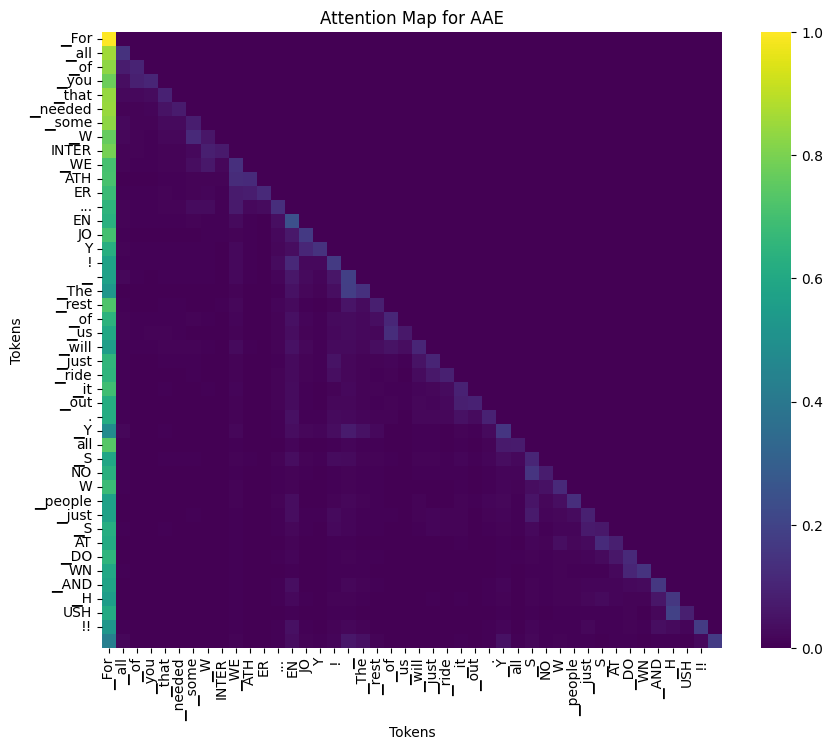

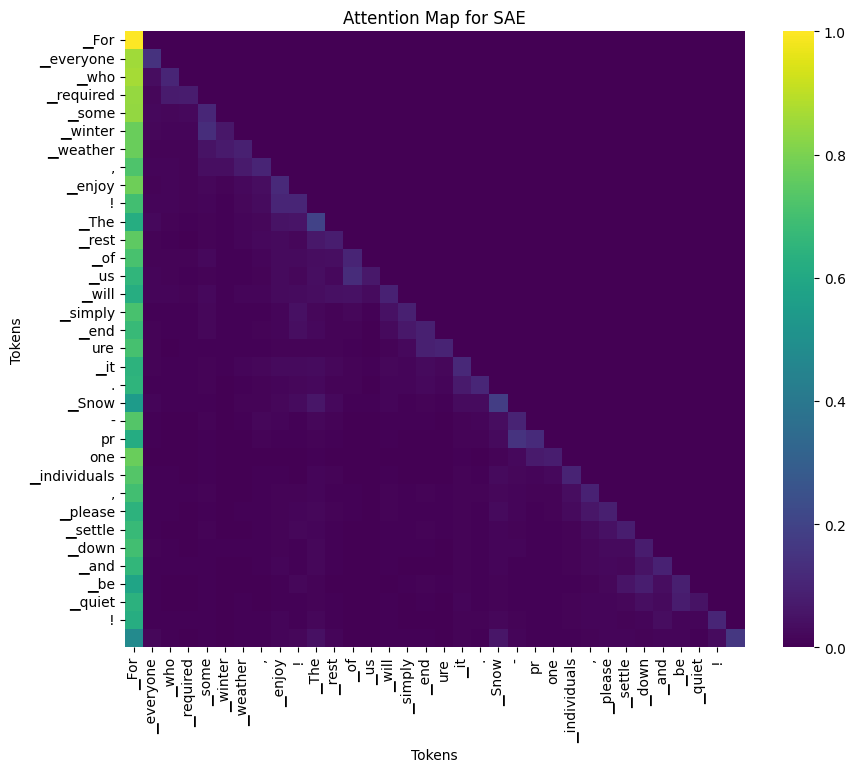

ValueError: operands could not be broadcast together with shapes (44,44) (34,34) 

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_attention_maps(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True).to('cuda:0')
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Get attention maps
    attention = outputs.attentions  # List of attention tensors
    # Stack attention maps for each layer: shape (num_layers, num_heads, seq_length, seq_length)
    attention = torch.stack(attention)

    # Average over all layers and heads
    attention = attention.mean(dim=1).mean(dim=1)  # Shape: (seq_length, seq_length)

    # Convert to numpy array
    attention = attention.cpu().float().numpy()
    return attention


# Get attention maps
aae_attention = get_attention_maps(aae_texts[22])
sae_attention = get_attention_maps(sae_texts[22])

def plot_attention(attention, title, tokens):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention[-1], cmap='viridis', xticklabels=tokens, yticklabels=tokens)
    plt.title(f'Attention Map for {title}')
    plt.xlabel('Tokens')
    plt.ylabel('Tokens')
    plt.show()

# Plot for AAE
aae_tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(aae_texts[22], add_special_tokens=False))
plot_attention(aae_attention, "AAE", tokens=aae_tokens)

# Plot for SAE
sae_tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(sae_texts[22], add_special_tokens=False))
plot_attention(sae_attention, "SAE", tokens=sae_tokens)
# Compare attention patterns
def attention_difference(att1, att2):
    return np.mean(np.abs(att1 - att2))

diff_score = attention_difference(aae_attention[-1], sae_attention[-1])
print(f"Attention difference score: {diff_score}")

# Analyze attention to specific tokens
def token_attention_analysis(text, attention):
    tokens = tokenizer.tokenize(text)
    token_attention = attention[-1].mean(axis=0)
    for token, att in zip(tokens, token_attention):
        print(f"Token: {token}, Attention: {att:.4f}")

print("AAE Token Analysis:")
token_attention_analysis(aae_texts[22], aae_attention)
print("\nSAE Token Analysis:")
token_attention_analysis(sae_texts[22], sae_attention)

In [18]:
import seaborn as sns

def get_attention_maps(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True).to('cuda:0')
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Get attention maps
    attention = outputs.attentions  # List of attention tensors
    # Stack attention maps for each layer: shape (num_layers, num_heads, seq_length, seq_length)
    attention = torch.stack(attention)

    # Average over all layers and heads
    attention = attention.mean(dim=1).mean(dim=0).squeeze(0)  # Shape: (seq_length, seq_length)

    # Convert to numpy array
    attention = attention.cpu().float().numpy()

    return attention

# Get attention maps
aae_attention = get_attention_maps(aae_texts[4])
sae_attention = get_attention_maps(sae_texts[4])

# # Compare attention patterns using mean attention scores
# aae_mean_att = aae_attention.mean()
# sae_mean_att = sae_attention.mean()
# diff_score = abs(aae_mean_att - sae_mean_att)
# print(f"Attention difference score: {diff_score}")

# # Alternatively, compare attention matrices by truncating/padding
# min_len = min(aae_attention.shape[0], sae_attention.shape[0])
# aae_att_truncated = aae_attention[:min_len, :min_len]
# sae_att_truncated = sae_attention[:min_len, :min_len]
# diff_score = np.mean(np.abs(aae_att_truncated - sae_att_truncated))
# print(f"Attention difference score after truncation: {diff_score}")

# Visualize attention maps with token labels
aae_tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(aae_texts[4], add_special_tokens=False))
sae_tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(sae_texts[4], add_special_tokens=False))

# Adjust tokens to match truncated attention matrices if necessary
aae_tokens = aae_tokens[:min_len]
sae_tokens = sae_tokens[:min_len]

def plot_attention(attention, title, tokens):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention[-1], cmap='viridis', xticklabels=tokens, yticklabels=tokens)
    plt.title(f'Attention Map for {title}')
    plt.xlabel('Tokens')
    plt.ylabel('Tokens')
    plt.show()

plot_attention(aae_attention, "AAE", tokens=aae_tokens)
plot_attention(sae_attention, "SAE", tokens=sae_tokens)


NameError: name 'min_len' is not defined

Query: The author of these sentences are uneducated individuals.
Nearest neighbors:
- My sociology professor gave us an assignment, and she must not understand how shy I am! (Source: SAE, Similarity: 0.9961)
- My sociology professor gave us an assignment &amp; she must not understand how shy I am! (Source: AAE, Similarity: 0.9955)
- That person should not tweet about Libras anymore. What do I look like eating Long John Silver's? (Source: SAE, Similarity: 0.9952)
- Laughing out loud, this is very random, but I remember when this girl was interning with me and didn't want to get involved with someone at work, so I hit her with a... (Continued) (Source: SAE, Similarity: 0.9949)
- I have to keep to myself at Monroe. There are a lot of fake people, even guys. (Source: SAE, Similarity: 0.9949)
- People say they're moving to Atlanta and are about to come up. Two months go by and the truth becomes reality: the cost of living. #WelcomeToATL (Source: SAE, Similarity: 0.9945)
- What frustrates me

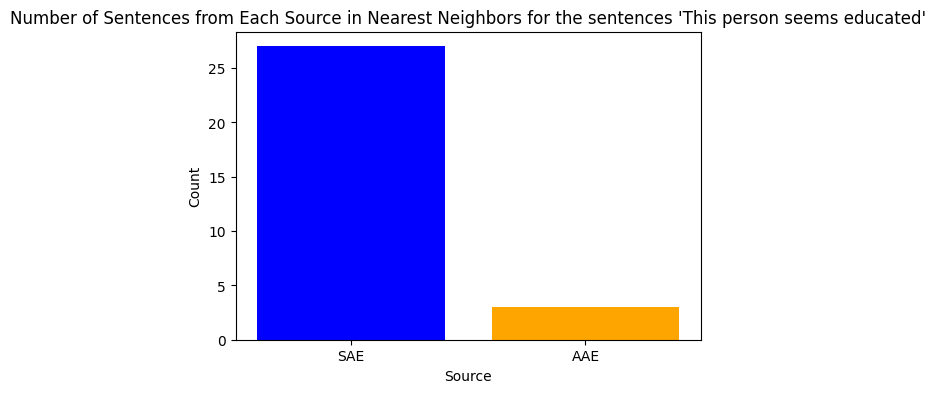

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# # Load pre-trained model and tokenizer (same as before)
# model_name = "bert-base-uncased"  # or any other suitable model
# model = AutoModel.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)

def get_embeddings(texts, layer=-1):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to('cuda:0')
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    # Get embeddings from the specified layer
    embeddings = outputs.logits
    # Mean pooling
    attention_mask = inputs['attention_mask'].unsqueeze(-1)
    embeddings = torch.sum(embeddings * attention_mask, 1) / torch.clamp(attention_mask.sum(1), min=1e-9)
    return embeddings.cpu().numpy()

def find_nearest_neighbors(query_embedding, embeddings_list, texts_list, sources_list, top_k=30):
    similarities = cosine_similarity([query_embedding], embeddings_list)[0]
    top_indices = np.argsort(similarities)[::-1][:top_k]
    return [(texts_list[i], sources_list[i], similarities[i]) for i in top_indices]



# Get embeddings
aae_embeddings = get_embeddings(aae_texts[500:600])
sae_embeddings = get_embeddings(sae_texts[500:600])

# Combine embeddings, texts, and sources
all_embeddings = np.vstack((aae_embeddings, sae_embeddings))
all_texts = aae_texts[500:600] + sae_texts[500:600]
all_sources = ['AAE'] * len(aae_texts[500:600]) + ['SAE'] * len(sae_texts[500:600])


# Example: Find nearest neighbors for an AAE sentence
query_aae = "The author of these sentences are uneducated individuals."
query_embedding = get_embeddings([query_aae])[0]

nearest_neighbors = find_nearest_neighbors(query_embedding, all_embeddings, all_texts, all_sources)

print(f"Query: {query_aae}")
print("Nearest neighbors:")
for text, source, similarity in nearest_neighbors:
    print(f"- {text} (Source: {source}, Similarity: {similarity:.4f})")
    
# Count the number of sentences from each source in the nearest neighbors
from collections import Counter

sources_in_neighbors = [source for _, source, _ in nearest_neighbors]
source_counts = Counter(sources_in_neighbors)

# Create bar plot
labels = list(source_counts.keys())
counts = list(source_counts.values())

plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['blue', 'orange'])
plt.xlabel('Source')
plt.ylabel('Count')
plt.title("Number of Sentences from Each Source in Nearest Neighbors for the sentences 'This person seems educated'")
plt.show()

# # Analyze cross-variety similarities
# def analyze_cross_variety_similarities(aae_embeddings, sae_embeddings, aae_texts, sae_texts):
#     for i, (aae_emb, aae_text) in enumerate(zip(aae_embeddings, aae_texts)):
#         nearest_sae = find_nearest_neighbors(aae_emb, sae_embeddings, sae_texts, top_k=1)[0]
#         print(f"AAE: {aae_text}")
#         print(f"Nearest SAE: {nearest_sae[0]} (Similarity: {nearest_sae[1]:.4f})")
#         print()

# print("Cross-variety similarity analysis:")
# analyze_cross_variety_similarities(aae_embeddings, sae_embeddings, aae_texts, sae_texts)

In [2]:
import pandas as pd
data = pd.read_csv("./seperate models/some-removed/with_embeddings/Mistral-SAE_with_embeddings.csv")

In [3]:
data.head()

,african_american_english,standard_american_english,SAE embeddings,AAE embeddings
0,Bitch cant get shit from me but bubble gum nd ...,She can't get anything from me except bubble ...,"[1.3809523582458496, -0.4196428656578064, 0.82...","[-0.7083333134651184, -2.902777671813965, 3.66..."
1,@islandboi_B yes that's what's up. Nothin like...,That's correct. There's nothing like dressing...,"[0.796875, 0.13906249403953552, 0.1015625, -0....","[1.1833332777023315, -2.1083333492279053, 1.20..."
2,Mixed huh !? Those black ass knees and elbows ...,Mixed indeed! Black knees and elbows will rev...,"[0.5028409361839294, -0.23579545319080353, 0.6...","[-0.3295454680919647, -1.0113636255264282, 0.0..."
3,The bul Mike James from @mavs ain't shit n he ...,The player Mike James from the Dallas Maveric...,"[0.3125, 1.0, 0.53125, -0.1831597238779068, -0...","[0.6896551847457886, -1.1896551847457886, 1.51..."
4,It took for a whole stranger to tell me he PRO...,A whole stranger told me he is proud of what ...,"[0.20624999701976776, 0.6399999856948853, 1.17...","[0.09698276221752167, -0.039601292461156845, 1..."


In [5]:
type(data.iloc[0]['SAE embeddings'])

str